In [2]:
'''Description: The aim of the experiment is to reconstruct a transmitted image, modulated by MPSK scheme,at the receiver.
The M in the M-PSK represents the maximum number of possible symbols (For Example: BPSK: M=2, QPSK: M=4). The maximum 
likelihood decoder will be used at the receiver to recover the symbols. To model a channel for transmission AWGN noise 
will be added to transmitted signal before processing at the receiver.The symbol error rate (SER) vs Es/N0 (in dB) and 
bit error rate (BER) vs Eb/N0 (in dB) will be plotted (where Es is the symbol energy, Eb is the bit energy and N0/2 is 
the AWGN noise variance) and will be compared with the theoretical value, .
Author: Hani Roshan CK
Date: 12/04/2023'''

'Description: The aim of the experiment is to reconstruct a transmitted image, modulated by MPSK scheme,at the receiver.\nThe M in the M-PSK represents the maximum number of possible symbols (For Example: BPSK: M=2, QPSK: M=4). The maximum \nlikelihood decoder will be used at the receiver to recover the symbols. To model a channel for transmission AWGN noise \nwill be added to transmitted signal before processing at the receiver.The symbol error rate (SER) vs Es/N0 (in dB) and \nbit error rate (BER) vs Eb/N0 (in dB) will be plotted (where Es is the symbol energy, Eb is the bit energy and N0/2 is \nthe AWGN noise variance) and will be compared with the theoretical value, .\nAuthor: Hani Roshan CK\nDate: 12/04/2023'

In [3]:
#Importing libraries
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

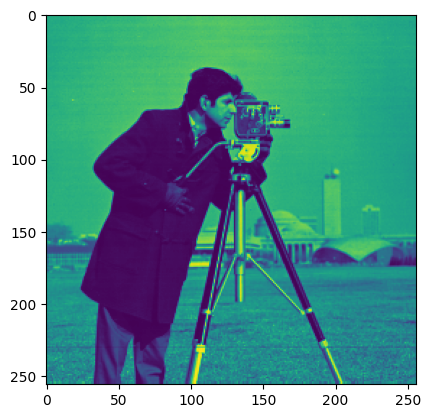

In [4]:
#Reading Image
image = imageio.imread('Desktop/cameraman.png')
plt.imshow(image)
plt.show()

In [5]:
#Converting from pixels to binary
rearranged_image=np.reshape(image, (1,65536))
binary_list=np.unpackbits(image)

In [6]:
#Generating MPSK symbols
'''
Description: The function is to generate symbols for a given M.
M-No. of symbols
'''
def generate_symbols(M):
    temp=[]
    for i in range(1,M+1):
        s=np.cos(2*np.pi*(i-1)/M)+1j*np.sin(2*np.pi*(i-1)/M)
        temp.append(s)
    return temp

In [7]:
#Grouping the bits based on M
'''
Description: The function is to group the pixel bits.
arr-pixel bit array
M-No. of symbols
'''
def group(arr,M):
    arr=list(arr)
    new_arr=[]
    if len(arr)%int(np.log2(M))!=0:
        arr=arr[:1+int(len(arr)/int(np.log2(M)))*int(np.log2(M))]+[0]*(int(np.log2(M))-len(arr[int(len(arr)/int(np.log2(M)))*int(np.log2(M)):]))+arr[1+int(len(arr)/int(np.log2(M)))*int(np.log2(M)):]
    for i in range(int(len(arr)/np.log2(M))):
        temp=''
        for j in range(int(np.log2(M))):
            temp=temp+str(arr[int(np.log2(M))*i+j])
        new_arr.append(temp)
    return new_arr

In [8]:
#converting the grouped bits into integers
'''
Description: The function is to change the grouped bits into integers.
arr-grouped bit array
'''
def convert_to_int(arr):
    temp=[]
    for i in arr:
        temp.append(int(i,2))
    return temp

In [9]:
#Mapping to symbols
'''
Description: The function is to map symbols.
arr-grouped and converted pixel array
symbol_arr-array containing the symbols we will be using
'''
def mapping(arr, symbol_arr):
    new_arr=[]
    for i in arr:
        new_arr.append(symbol_arr[i])
    return new_arr

In [10]:
#Making the constellation diagram
'''
Description: The function is to make a constellation diagram of the given array.
arr-mapped pixel array
M-no. of symbols
'''
def draw_constellation(arr, M):
    new_arr=np.array(arr)
    plt.scatter(new_arr.real,new_arr.imag)

In [11]:
#Making awgn and adding noise
'''
Description: The function is to make and add noise to the mapped array.
snr-snr in dB
arr-mapped pixel array
M-number of symbols
'''
def gen_and_add_noise(snr, arr, M):
    num=len(arr)
    new_arr=np.array(arr)
    sigma=np.sqrt(1/(10**(snr/10)))
    wgn=np.random.normal(0,sigma/np.sqrt(M),num)+1j*np.random.normal(0,sigma/np.sqrt(M),num)
    recieved_signal=new_arr+wgn
    return recieved_signal

In [12]:
#ML decoding
'''
Description: The function is to decode the noise added array.
arr-noise added array
symbols-symbol array
'''
def decoding(arr, symbols):
    temp=[]
    for i in range(len(arr)):
        absolutes=[]
        for j in range(len(symbols)):
            absolutes.append(np.abs(arr[i]+symbols[j]))
        temp.append(symbols[absolutes.index(max(absolutes))])
    return temp

In [13]:
#Demapping symbols to integers
'''
Description: The function is to demap given array to integers.
arr-decoded array
symbols-symbol array
'''
def demap(arr, symbols):
    new_arr=np.round(arr)
    new_symbols=list(np.round(symbols))
    temp=[]
    for i in range(len(arr)):
        temp.append(new_symbols.index(new_arr[i]))
    return temp

In [14]:
#converting integers to binary
'''
Description: The function is to demap given array to binary.
arr-integer demapped array
M-number of symbols
'''
def convert_to_bits(arr,M):
    temp=[]
    for i in arr:
        binary=bin(i)
        new_binary='0'*(abs(len(binary[2:])-int(np.log2(M))))+binary[2:]
        temp.append(new_binary)
    return temp

In [15]:
#seperating binary into bits
'''
Description: The function is to seperate the binary values into bits for finding BER.
arr-binary array
'''
def seperate(arr):
    temp=''.join(arr)
    fin=[]
    for i in range(len(temp)):
        fin.append(int(temp[i]))
    return fin

In [16]:
#Grouping binary values to 8 bit binary and coverting to pixel values
'''
Description: The function is to group the binary values into 8 bit groups and then to pixel values.
arr-binary array
'''
def join_bits(arr):
    temp=''.join(arr)
    fin=[]
    for i in range(int(len(temp)/8)):
        fin.append(int(temp[8*i:8*i+8],2))
    rearranged=np.reshape(fin,(256,256))
    return rearranged

In [17]:
#Finding SER or BER
'''
Description: The function is to find the SER or BER depending on the array fed.
arr1-symbol/binary array before transmission
arr2-symbol/binary array after transmission
'''
def find_ker(arr1, arr2):
    ke=0
    arr1=list(arr1)
    arr2=list(arr2)
    for i in range(len(arr1)):
        if arr1[i]!=arr2[i]:
            ke=ke+1
    return ke/len(arr1)

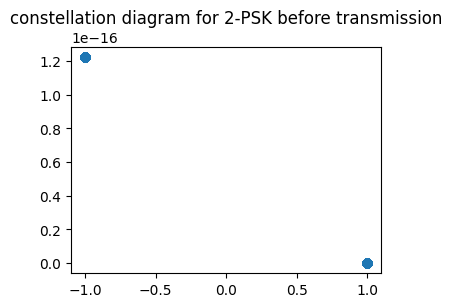

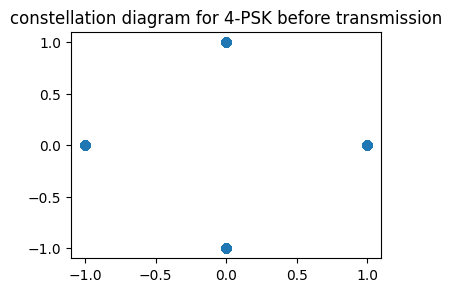

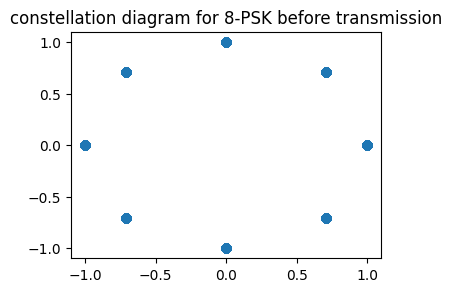

In [18]:
M=[2,4,8]
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,M.index(i)+1)
    #formerly draw_constellation(np.round(mapped), i)
    draw_constellation(mapped, i)
    plt.title("constellation diagram for "+str(i)+"-PSK before transmission")

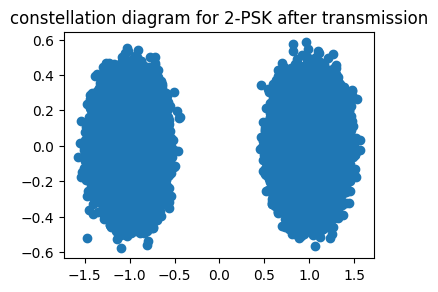

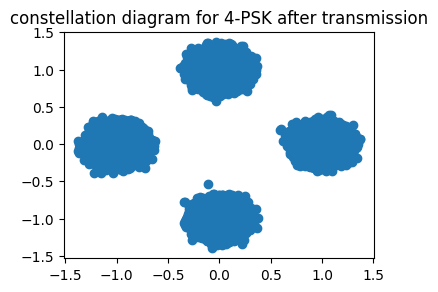

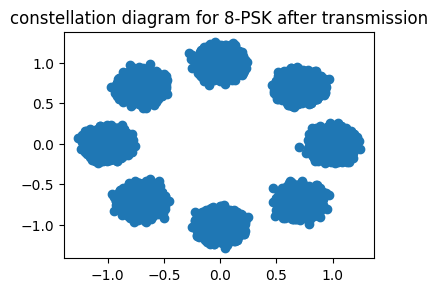

In [19]:
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    snr_dB=15
    recieved=gen_and_add_noise(snr_dB, mapped, i)
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,M.index(i)+1)
    draw_constellation(recieved, i)
    plt.title("constellation diagram for "+str(i)+"-PSK after transmission")

In [20]:
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    snr_dB=15
    recieved=gen_and_add_noise(snr_dB, mapped, i)
    decode1=decoding(recieved, symbols)
    decode2=demap(decode1, symbols)
    converted2=convert_to_bits(decode2,i)
    joined=join_bits(converted2)
    seperated=seperate(converted2)
    ber=find_ker(binary_list, seperated)
    ser=find_ker(mapped, decode1)
    print('SER for '+str(i)+'-PSK='+str(ser))
    print('BER for '+str(i)+'-PSK='+str(ber))

SER for 2-PSK=0.0
BER for 2-PSK=0.0
SER for 4-PSK=0.0
BER for 4-PSK=0.0
SER for 8-PSK=0.0
BER for 8-PSK=1.9073486328125e-06


Lossy conversion from int32 to uint8. Range [7, 253]. Convert image to uint8 prior to saving to suppress this warning.


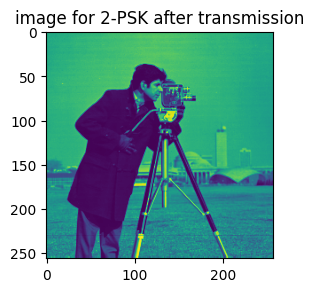

Lossy conversion from int32 to uint8. Range [7, 253]. Convert image to uint8 prior to saving to suppress this warning.


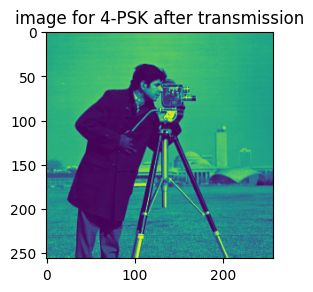

Lossy conversion from int32 to uint8. Range [7, 253]. Convert image to uint8 prior to saving to suppress this warning.


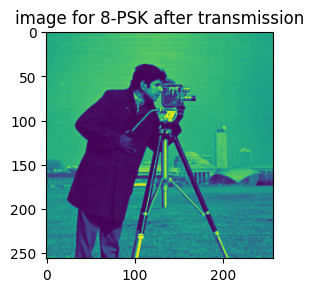

In [21]:
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    snr_dB=15
    recieved=gen_and_add_noise(snr_dB, mapped, i)
    decode1=np.round(decoding(recieved, symbols))
    decode2=demap(decode1, symbols)
    converted2=convert_to_bits(decode2,i)
    joined=join_bits(converted2)
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    imageio.imwrite('recieved_image.png', joined)
    recieved_image=imageio.imread('recieved_image.png')
    plt.subplot(3,1,M.index(i)+1)
    plt.title("image for "+str(i)+"-PSK after transmission")
    plt.imshow(recieved_image)
    plt.show()

In [22]:
snr_dB=np.arange(-10,11,1)
ber_arr=[]
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    temp=[]
    for j in range(len(snr_dB)):
        recieved=gen_and_add_noise(snr_dB[j], mapped, i)
        decode1=np.round(decoding(recieved, symbols))
        decode2=demap(decode1, symbols)
        converted2=convert_to_bits(decode2,i)
        joined=join_bits(converted2)
        seperated=seperate(converted2)
        ber=find_ker(binary_list, seperated)
        temp.append(ber)
    ber_arr.append(temp)

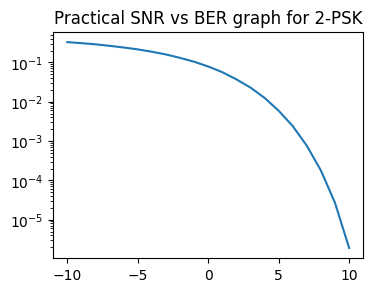

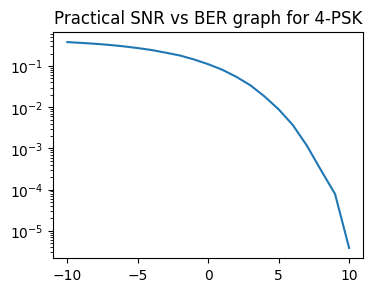

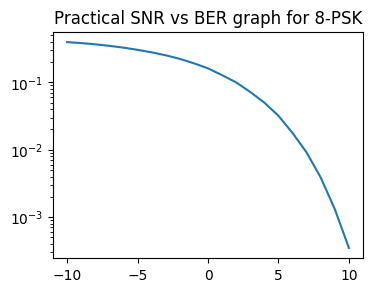

In [23]:
for i in range(len(ber_arr)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ber_arr[i])
    plt.title("Practical SNR vs BER graph for "+str(M[i])+"-PSK")

In [24]:
snr_dB=np.arange(-10,11,1)
ser_arr=[]
for i in M:
    symbols=generate_symbols(i)
    grouped=group(binary_list,i)
    converted=convert_to_int(grouped)
    mapped=mapping(converted, symbols)
    temp=[]
    for j in range(len(snr_dB)):
        recieved=gen_and_add_noise(snr_dB[j], mapped, i)
        decode1=decoding(recieved, symbols)
        decode2=demap(decode1, symbols)
        converted2=convert_to_bits(decode2,i)
        joined=join_bits(converted2)
        seperated=seperate(converted2)
        ser=find_ker(mapped, decode1)
        temp.append(ser)
    ser_arr.append(temp)

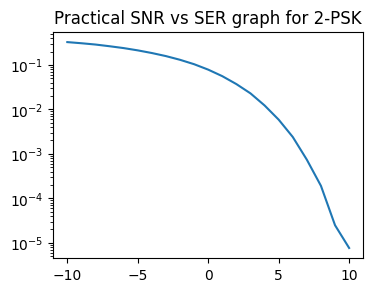

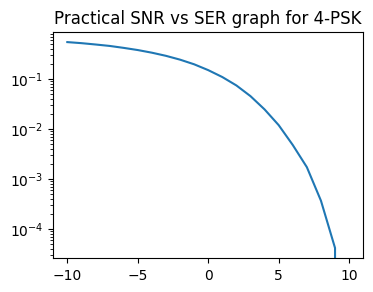

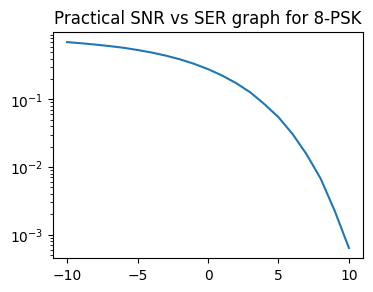

In [25]:
for i in range(len(ser_arr)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ser_arr[i])
    plt.title("Practical SNR vs SER graph for "+str(M[i])+"-PSK")

In [26]:
def q_function(x):
    q_x,_= quad(lambda t: np.exp(-t**2/2), x, np.inf)
    q_x = q_x/np.sqrt(2 * np.pi)
    return q_x

In [27]:
snr_dB=np.arange(-10,11,1)
snr_lin=10**(snr_dB/10)
M=[2,4,8]
ber_theory=[]
for j in M:
    temp=[]
    for i in range(len(snr_dB)):
        arg=np.sqrt(2*snr_lin[i])*np.sin(np.pi/j)
        temp.append((2/int(np.log2(j)))*q_function(arg))
    ber_theory.append(temp)

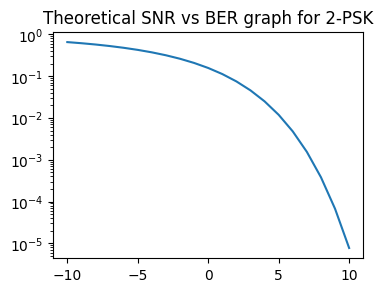

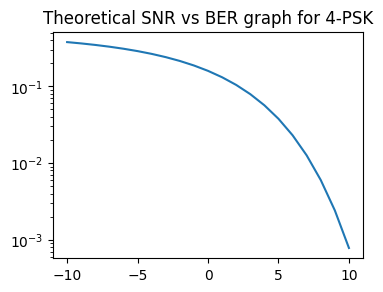

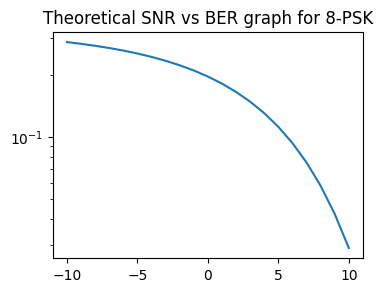

In [28]:
for i in range(len(ber_theory)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ber_theory[i])
    plt.title("Theoretical SNR vs BER graph for "+str(M[i])+"-PSK")

In [29]:
snr_dB=np.arange(-10,11,1)
snr_lin=10**(snr_dB/10)
M=[2,4,8]
ser_theory=[]
for j in M:
    temp=[]
    for i in range(len(snr_dB)):
        arg=np.sqrt(2*snr_lin[i])*np.sin(np.pi/j)
        temp.append(2*q_function(arg))
    ser_theory.append(temp)

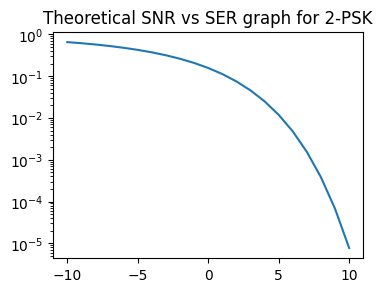

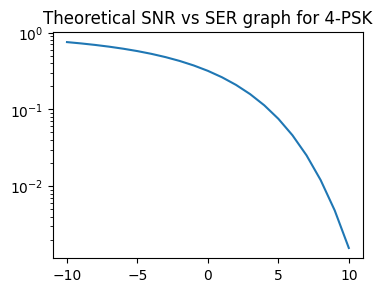

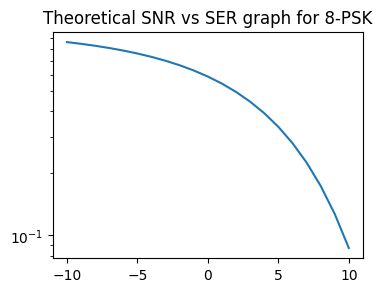

In [30]:
for i in range(len(ser_arr)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ser_theory[i])
    plt.title("Theoretical SNR vs SER graph for "+str(M[i])+"-PSK")

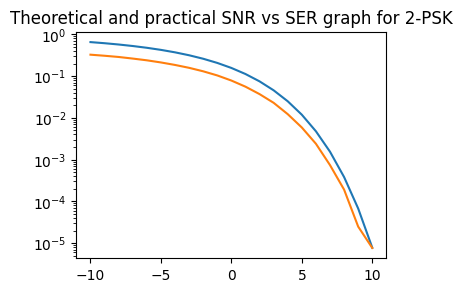

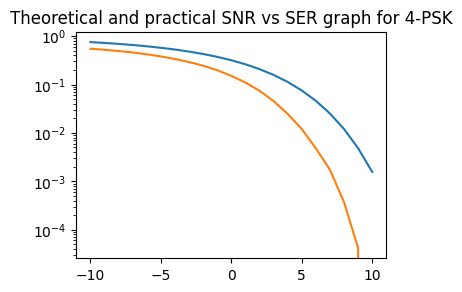

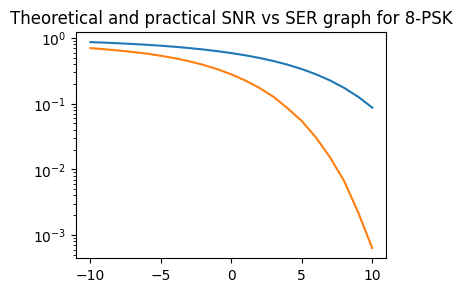

In [31]:
for i in range(len(ser_arr)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ser_theory[i])
    plt.semilogy(snr_dB, ser_arr[i])
    plt.title("Theoretical and practical SNR vs SER graph for "+str(M[i])+"-PSK")

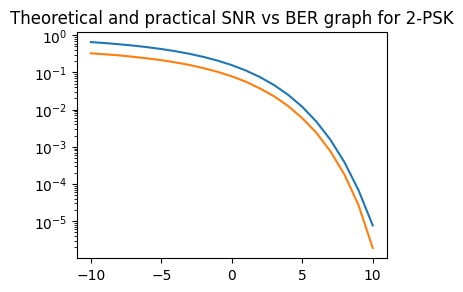

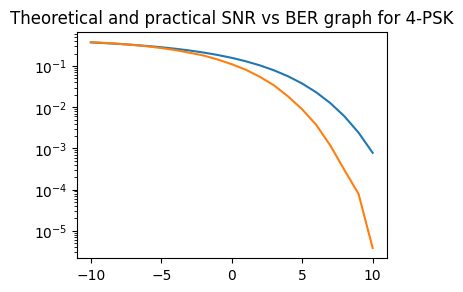

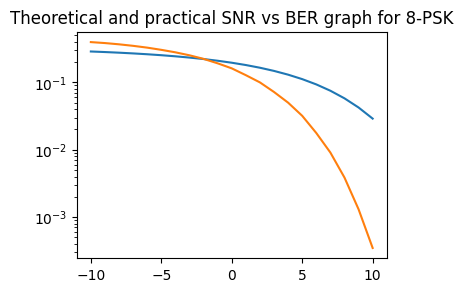

In [32]:
for i in range(len(ser_arr)):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(10)
    plt.subplot(3,1,i+1)
    plt.semilogy(snr_dB, ber_theory[i])
    plt.semilogy(snr_dB, ber_arr[i])
    plt.title("Theoretical and practical SNR vs BER graph for "+str(M[i])+"-PSK")